In [1]:
%matplotlib inline

##Initialize SVC

In [27]:
from nilearn.input_data import NiftiMasker
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [28]:
k = 500
feature_selection = SelectKBest(f_classif, k=k)
svc = SVC()
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

In [5]:
anova_svc

Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7fa37357cde8>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

##Load Mask

In [29]:
import epi_prediction
white_matter = epi_prediction.SimpleMasker('masks/white.nii', threshold=.2)

In [30]:
white_matter

<epi_prediction.SimpleMasker instance at 0x7f3642023830>

In [31]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_img

/home/lbuser/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1256: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


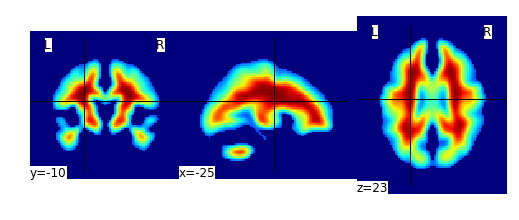

In [32]:
plot_img(white_matter._mask_image)
plt.show()

##Import Data

In [33]:
import epi_prediction
src_dir = '/home/lbuser/data/chuyu/process_normalize/'
control_filter = lambda file_name: 'CON' in file_name
patient_filter = lambda file_name: 'PAT' in file_name

In [34]:
epi_paths = epi_prediction.get_epi_paths(src_dir, patient_filter, control_filter)


In [35]:
dmean_paths = epi_paths['dmean']

In [36]:
dmean_paths

cons    [/home/lbuser/data/chuyu/process_normalize/dme...
pats    [/home/lbuser/data/chuyu/process_normalize/dme...
Name: dmean, dtype: object

In [37]:
mat = white_matter.transform_many(dmean_paths['pats'] + dmean_paths['cons'], verbose=True)

--------------------------------------------------------------------
####################################################################

In [38]:
mat.shape

(68, 134263)

In [39]:
labels = len(dmean_paths['pats']) * [1] + len(dmean_paths['cons']) * [0]

In [40]:
len(labels)

68

##Grid Search for Best Parameters of Gamma and C

In [41]:
from sklearn.grid_search import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(svc__gamma=gamma_range, svc__C=C_range)
n_folds = np.floor_divide(32, 5)

cv = StratifiedKFold(labels, n_folds=n_folds)

In [42]:
total_runs = len(C_range) * len(gamma_range) * n_folds

scorer = epi_prediction.verbose_scorer(total_runs)
grid = GridSearchCV(anova_svc, param_grid=param_grid, cv=cv, scoring = scorer)

grid.fit(mat, labels)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=6, shuffle=False, random_state=None),
       estimator=Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7f364848ade8>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'svc__gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'svc__C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
      

In [43]:
scores = [x[1] for x in grid.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))
scores

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.52048319,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.68459653,  0.67356712,  0.70360644,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.69930241,  0.67742184,  0.63351159,  0.6689722 ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.69930241,
         0.66565714,  0.61047237,  0.62272727,  0.6689722 ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.      

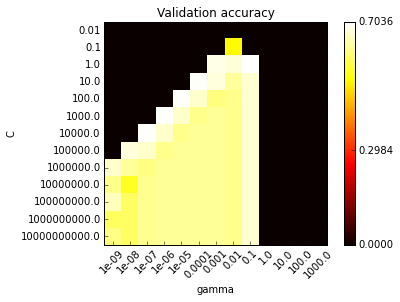

In [44]:
cax = plt.imshow(scores, interpolation="nearest", cmap=plt.cm.hot)
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.xlabel('gamma')
plt.yticks(np.arange(len(C_range)), C_range)
plt.ylabel('C')
plt.title('Validation accuracy')

cbar = plt.colorbar(cax, ticks=[np.min(scores), np.mean(scores), np.max(scores)])

plt.show()

In [45]:
scores.shape

(13, 13)

In [46]:
np.max(scores)

0.70360644257703076

##Calculate Confusion Matrix

In [49]:
C = C_range[2]
gamma = gamma_range[8]
scores[2][8]

0.70360644257703076

In [50]:
anova_svc.set_params(svc__C=C, svc__gamma=gamma)

Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7f364848ade8>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.10000000000000001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False))])

In [51]:
cv = StratifiedKFold(labels, n_folds=n_folds)

labels_arr = np.array(labels)

cv_info, cv_info_train = epi_prediction.verbose_cv(mat, labels_arr, anova_svc, n_folds=6, verbose=False)

####
####
####
####
####
####


In [52]:
cv_info.confusion_matrix()

array([[22, 14],
       [ 7, 25]])

In [53]:
cv_info.normalized_confusion_matrix()

array([[ 0.61111111,  0.38888889],
       [ 0.21875   ,  0.78125   ]])

##Leave 1 Out Cross Validation

In [54]:
cv = StratifiedKFold(labels, n_folds=n_folds)

labels_arr = np.array(labels)

cv_info_1_out, cv_info_train_1_out = epi_prediction.verbose_cv(mat, 
                                                   labels_arr, 
                                                   anova_svc,
                                                   n_folds=31,
                                                   verbose=False)

####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####


In [55]:
cv_info_1_out.confusion_matrix()

array([[21, 15],
       [ 9, 23]])

In [56]:
cv_info_1_out.normalized_confusion_matrix()

array([[ 0.58333333,  0.41666667],
       [ 0.28125   ,  0.71875   ]])

In [57]:
cv_info_1_out.avg_f1_score()

0.59677419354838701

In [58]:
cv_info.avg_f1_score()

0.70400432900432897

##Retrieve Voxels

__Retrieving Important Voxels Requires Linear Classifier__

In [59]:
svc = SVC()
anova_svc_lin = Pipeline( [('anova', SelectKBest(k=500)), ('svc', svc)] )
anova_svc_lin.set_params(svc__kernel='linear')

Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7f364848ade8>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [60]:
C_range_lin = np.logspace(-3, 3, 7)

total_runs = len(C_range_lin) * n_folds

scorer = epi_prediction.verbose_scorer(total_runs)
grid_lin = GridSearchCV(anova_svc_lin, param_grid={"svc__C": C_range_lin}, cv=cv, scoring = scorer)

grid_lin.fit(mat, labels_arr)

------------------------------------------
##########################################

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=6, shuffle=False, random_state=None),
       estimator=Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7f364848ade8>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'svc__C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=make_scorer(verbose_score_fn), verbose=0)

In [61]:
grid_lin.grid_scores_

[mean: 0.63725, std: 0.10393, params: {'svc__C': 0.001},
 mean: 0.65490, std: 0.09938, params: {'svc__C': 0.01},
 mean: 0.54724, std: 0.16056, params: {'svc__C': 0.10000000000000001},
 mean: 0.63106, std: 0.15233, params: {'svc__C': 1.0},
 mean: 0.63106, std: 0.15233, params: {'svc__C': 10.0},
 mean: 0.63106, std: 0.15233, params: {'svc__C': 100.0},
 mean: 0.63106, std: 0.15233, params: {'svc__C': 1000.0}]

In [62]:
anova_svc_lin.set_params(svc__C=.01)

Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7f364848ade8>)), ('svc', SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [66]:
anova = anova_svc_lin.named_steps['anova']

coeffs = np.zeros(white_matter._mask_image.shape)
for train, test in cv:
    expected = labels_arr[test]
    anova_svc_lin.fit(mat[train], labels_arr[train])
    coeffs = coeffs + np.abs(white_matter.inv_transform(anova.inverse_transform(svc.coef_)))

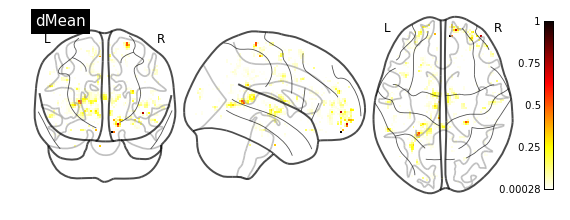

In [70]:
import nibabel as nib

from nilearn.plotting import plot_glass_brain
coeffs_normalized = coeffs/np.max(coeffs)
plot_glass_brain(nib.Nifti1Image(coeffs_normalized, 
                                 affine = white_matter._mask_image.get_affine()), 
                 title="dMean",
                 colorbar=True)

##Generate Linear Confusion Matrix

In [2]:
labels_arr = np.array(labels)

cv_info_lin, cv_info_train_lin = epi_prediction.verbose_cv(mat, labels_arr, anova_svc_lin, n_folds=6)

NameError: name 'np' is not defined

In [1]:
cv_info_lin.confusion_matrix()

NameError: name 'cv_info_lin' is not defined

In [73]:
cv_info_lin.normalized_confusion_matrix()

array([[ 0.75 ,  0.25 ],
       [ 0.375,  0.625]])

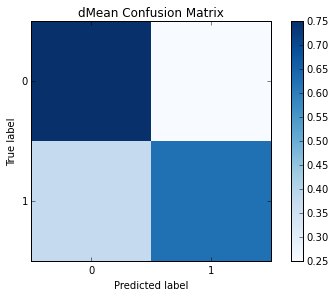

In [75]:
epi_prediction.plot_confusion_matrix(cv_info_lin.normalized_confusion_matrix(), "dMean Confusion Matrix")

In [76]:
cv_info_lin.avg_f1_score()

0.65555555555555545

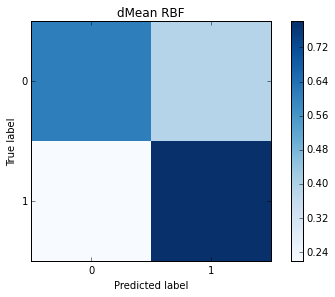

In [77]:
epi_prediction.plot_confusion_matrix(cv_info.normalized_confusion_matrix(), "dMean RBF")